# Classifying Thoracic Conditions From Chest X-Rays Using DenseNet121

This notebook was submitted as part of the [Grand X-Ray Slam: Division A Competition](https://www.kaggle.com/competitions/grand-xray-slam-division-a/overview). The goal of this competition was to advance medical imaging by using medical X-Ray images for multilabel classification of chest conditions.

In [1]:
#Loading necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

import os
import torch
import re

from torchvision import transforms, models # Deep Learning Library used for importing DenseNet121 model to train images
from torch.utils.data import Subset,Dataset, DataLoader
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import random_split
from tqdm import tqdm
from sklearn.metrics import roc_auc_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


folder = "/kaggle/input/grand-xray-slam-division-a"
files = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if os.path.isfile(os.path.join(folder, f))
]

print(files)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/grand-xray-slam-division-a/sample_submission_1.csv', '/kaggle/input/grand-xray-slam-division-a/train1.csv']


# Initial Exploration

The 14 classifications that will be predicted from the image dataset are: 
1. **Atelectasis**: A condition referring to the partial or complete collapse of a lung
2. **Cardiomegaly**: An enlarged heart, which is typically indicative of other underlying conditions
3. **Consolidation**: A condition characterized by fluid, solid, or other material filling the airways in the lungs. It can sometimes be caused by other conditions such as Pneumonia.
4. **Edema**: Swelling present somewhere in the field of view of the image. 
5. **Enlarged Cardiomediastinum**: An enlargement of the thoracic cavity containing the heart. It may be a sign of other underlying conditions such as Cardiomegaly.
6. **Fracture**: A fracture of a bone present within the field of view of the image.
7. **Lung Lesion**: An abnormal area in the lung tissue, including nodules or other masses.
8. **Lung Opacity**: An area of the X-ray showing higher than usual density of white pixels, presenting a more white area compared to grey or black.
9. **No Finding**: Indicates that none of the outlined diagnoses were observed in the image.
10. **Pleural Effusion**: Refers to the accumulation of fluid in the area between the lungs and the chest wall.
11. **Pleural Other**: A catch-all condition used to indicate an unspecified abnormality in the X-ray that doesn't neatly fit into the other conditions.
13. **Pneumonia**: Inflammation of the air sacs in the lungs
14. **Pneumothorax**: A collapsed lung caused by air leaking into the intrapleural space.
15. **Support Devices**: Indicates the presence of supportive devices in the image (e.g. pacemaker).

When examining the training dataset, we see a breakdown of: 
- 48% Atelectasis
- 32.6% Cardiomegaly
- 44.5% Consolidation
- 24.8% Edema
- 35.3% Enlarged Cardiomediastinum
- 14.0% Fracture
- 11.1% Lung Lesion
- 45.3% Lung Opacity
- 31.6% with No Finding present
- 6.6% with Other Pleural Abnormalities present
- 13.4% Pneumonia
- 8.2% Pneumothorax
- 35.1% Support Devices

In [19]:
train1 = pd.read_csv('/kaggle/input/grand-xray-slam-division-a/train1.csv')

LABEL_COLUMNS = ['Atelectasis',
                'Cardiomegaly',
                'Consolidation',
                'Edema',
                'Enlarged Cardiomediastinum',
                'Fracture',
                'Lung Lesion',
                'Lung Opacity',
                'No Finding',
                'Pleural Effusion',
                'Pleural Other',
                 'Pneumonia',
                'Pneumothorax',
                'Support Devices']

train1[LABEL_COLUMNS].describe()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
count,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000,107374.000000
mean,0.361670,0.325963,0.273660,0.248393,0.352562,0.139550,0.110818,0.452866,0.316250,0.318904,0.065761,0.133915,0.082087,0.350746
std,0.480486,0.468736,0.445839,0.432083,0.477770,0.346521,0.313908,0.497776,0.465014,0.466054,0.247865,0.340563,0.274498,0.477206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualizing the Data

Here, we start by simply looking at an example image alongside its corresponding classifications. This is an image of a male patient presenting with: 
- Atelectasis
- Pneumothorax
- Fracture
- Lung Opacity
- Support Devices

In [20]:
def present_xray_image(df, image_dir, image_idx = 42):
    fig, ax = plt.subplots(figsize=(11,8))
    filename = df.iloc[image_idx, 0]
    image_path = os.path.join(image_dir,filename)
    
    image = Image.open(image_path)
    ax.imshow(image)
    plt.show()
    print(f"Patient ID: {df.loc[image_idx,'Patient_ID']} \n\
    Sex: {df.loc[image_idx,'Sex']} \n\
    Atelectasis Dx: {df.loc[image_idx,'Atelectasis']} \n\
    Cardiomegaly Dx: {df.loc[image_idx,'Cardiomegaly']} \n\
    Consolidation Dx: {df.loc[image_idx, 'Consolidation']} \n\
    Edema Dx: {df.loc[image_idx,'Edema']} \n\
    Enlarged Cardiomediastinum Dx: {df.loc[image_idx,'Enlarged Cardiomediastinum']} \n\
    Fracture Dx: {df.loc[image_idx,'Fracture']} \n\
    Lung Lesion Dx: {df.loc[image_idx,'Lung Lesion']} \n\
    Lung Opacity Dx: {df.loc[image_idx, 'Lung Opacity']} \n\
    No Finding Dx: {df.loc[image_idx,'No Finding']} \n\
    Pleural Effusion Dx: {df.loc[image_idx, 'Pleural Effusion']} \n\
    Pleural Other Dx: {df.loc[image_idx, 'Pleural Other']} \n\
    Pneumonia Dx: {df.loc[image_idx, 'Pneumonia']} \n\
    Pneumothorax Dx: {df.loc[image_idx,'Pneumothorax']} \n\
    Support Devices Dx: {df.loc[image_idx, 'Support Devices']}")
    

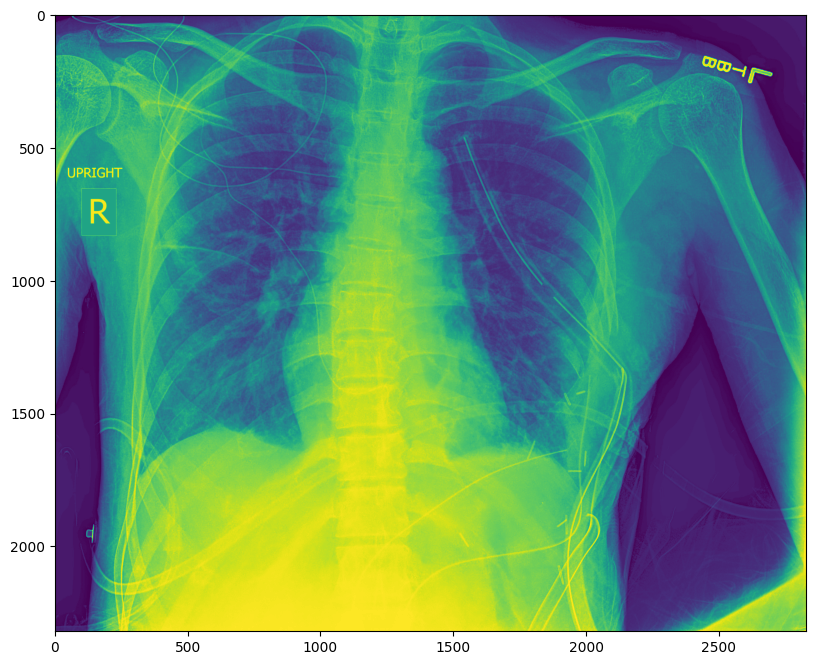

Patient ID: 39 
    Sex: Female 
    Atelectasis Dx: 1 
    Cardiomegaly Dx: 0 
    Consolidation Dx: 0 
    Edema Dx: 0 
    Enlarged Cardiomediastinum Dx: 0 
    Fracture Dx: 1 
    Lung Lesion Dx: 0 
    Lung Opacity Dx: 1 
    No Finding Dx: 0 
    Pleural Effusion Dx: 0 
    Pleural Other Dx: 0 
    Pneumonia Dx: 0 
    Pneumothorax Dx: 1 
    Support Devices Dx: 1


In [17]:
image_dir = "/kaggle/input/grand-xray-slam-division-a/train1"
present_xray_image(train1,image_dir=image_dir, image_idx = 56)

# Creating the Dataset

In [ ]:
class XRayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform # The specific transform used to preprocess images

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.loc[idx, "Image_name"].strip()
        labels = torch.tensor(
            self.annotations.loc[idx, LABEL_COLUMNS].values.astype(float),
            dtype=torch.float32
        )

        img_path = os.path.join(self.img_dir, filename)

        try:
            image = Image.open(img_path).convert("L")
        except Exception as e:
            print(f"Error opening {img_path}: {e}")
            return None, None

        image = image.convert("RGB")  # DenseNet expects 3 channels

        if self.transform:
            image = self.transform(image)

        return image, labels

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # random crop & resize
    transforms.RandomHorizontalFlip(p=0.5),                # flip left-right
    transforms.RandomRotation(15),                         # small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],# Standard values used for DenseNet121
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),  # keep validation/test deterministic
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [ ]:
full_dataset = XRayDataset(csv_file = "/kaggle/input/grand-xray-slam-division-a/train1.csv",
                           img_dir = '/kaggle/input/grand-xray-slam-division-a/train1',
                           transform = train_transform)

# split into train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Give val_dataset the "val_transform"
val_dataset.dataset.transform = val_transform  

# loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Creating and Training the Model

For this competition, I will be using a Pretrained DenseNet121 model, a convolutional neural network built on the DenseNet architecture. 

In [ ]:
model = models.densenet121(pretrained=True)

num_classes = len(LABEL_COLUMNS)

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:


# Make sure checkpoint folder exists
input_checkpoint_dir = "/kaggle/input/checkpoint-epoch-4"  
checkpoint_dir = "/kaggle/working"  
os.makedirs(checkpoint_dir, exist_ok=True)


num_epochs = 7 # Number of epochs used for training
roc_auc_interval = 500  # Interval for calculating updated ROC AUC on set number of training batches
# ---- Resume from checkpoint if available ----
# Path to input checkpoint dataset
input_checkpoint_dir = "/kaggle/input/checkpoint-epoch-4"  

start_epoch = 0
scaler = GradScaler()

# Look for checkpoint in input dataset
checkpoint_files = [f for f in os.listdir(input_checkpoint_dir) if f.startswith("checkpoint_epoch") and f.endswith(".pth")]
if checkpoint_files:
    # Pick the checkpoint with the highest epoch number
    latest_ckpt = max(checkpoint_files, key=lambda x: int(re.search(r"checkpoint_epoch(\d+)", x).group(1)))
   checkpoint_path = os.path.join(input_checkpoint_dir, latest_ckpt)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scaler.load_state_dict(checkpoint["scaler_state"])
    start_epoch = checkpoint["epoch"] + 1

   print(f"Resuming from {latest_ckpt}, starting at epoch {start_epoch+1}/{num_epochs}")
else:
    print("No checkpoint found, starting fresh.")

# ---- Training loop ----
for epoch in range(start_epoch, num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    model.train()
    all_labels_epoch, all_probs_epoch = [], []
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        if images is None:
            continue

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backprop with GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Store predictions for ROC AUC
        probs = torch.sigmoid(outputs).detach().cpu()
        all_probs_epoch.append(probs)
        all_labels_epoch.append(labels.detach().cpu())

        # Compute running ROC AUC periodically
        if (batch_idx + 1) % roc_auc_interval == 0:
            batch_probs = torch.cat(all_probs_epoch, dim=0).numpy()
            batch_labels = torch.cat(all_labels_epoch, dim=0).numpy()
            batch_roc_auc = roc_auc_score(batch_labels, batch_probs, average="macro")
            print(f"Batch {batch_idx+1} ROC AUC (training, running): {batch_roc_auc:.4f}")

    # ---- Epoch-level Training ROC AUC ----
    all_probs_epoch = torch.cat(all_probs_epoch, dim=0).numpy()
    all_labels_epoch = torch.cat(all_labels_epoch, dim=0).numpy()
    epoch_roc_auc = roc_auc_score(all_labels_epoch, all_probs_epoch, average="macro")
    avg_loss = running_loss / (batch_idx + 1)
    print(f"Epoch {epoch+1} finished. Training Avg Loss: {avg_loss:.4f}, ROC AUC: {epoch_roc_auc:.4f}")

    # ---- Validation ROC AUC ----
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for val_images, val_labels_batch in tqdm(val_loader, desc="Validating"):
            val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
            with autocast():
                val_outputs = model(val_images)
            probs = torch.sigmoid(val_outputs).detach().cpu()
            val_probs.append(probs)
            val_labels.append(val_labels_batch.detach().cpu())

    val_probs = torch.cat(val_probs, dim=0).numpy()
    val_labels = torch.cat(val_labels, dim=0).numpy()
    val_roc_auc = roc_auc_score(val_labels, val_probs, average="macro")
    print(f"Validation ROC AUC after Epoch {epoch+1}: {val_roc_auc:.4f}")

    # ---- Save checkpoint ----
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pth")
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

# ---- Save final model weights ----
final_model_path = "/kaggle/working/densenet121_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model weights saved to {final_model_path}")


# Test Set Predictions and Submission

In [ ]:
test_dataset = XRayDataset(
    img_dir = '/kaggle/input/grand-xray-slam-division-a/test1',
    csv_file = None,
    label_columns = None,
    transforms = val_transforms
)

test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:
all_probs = []
all_preds = []
all_files = []

sigmoid - nn.Sigmoid()

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = sigmoid(outputs)
        preds = (probs > 0.5).int()

    all_probs.extend(probs.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())
    all_files.extend(filenames)

In [ ]:
df_probs = pd.DataFrame(all_probs,columns = LABEL_COLUMNS)
df_probs.insert(0,"Image_name", all_files)
df_preds = pd.DataFrame(all_preds,columns = LABEL_COLUMNS)

In [ ]:
df_probs.to_csv('submission.csv')